In [1]:
import pandas as pd
import numpy as np


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error



target = 'duration'
categorical = ['PUlocationID', 'DOlocationID']


def read_dataset(file, categorical=categorical):
    df = pd.read_parquet(file)
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    df = df[(df.duration <= 60) & (df.duration >= 1)] 
    df[categorical] = df[categorical].fillna(-1)
    df[categorical] = df[categorical].astype(int).astype(str)
    return df.copy()

### EDA

In [2]:
df = pd.read_parquet('data/fhv_tripdata_2021-01.parquet')
df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

**1) Number of records in Jan 2021 FHV data**


In [3]:
df.shape

(1154112, 8)

**2) Average duration in Jan 2021 FHV**


In [4]:
df.duration.mean()

19.167224093791006

**3) Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).**

How many records did you drop?

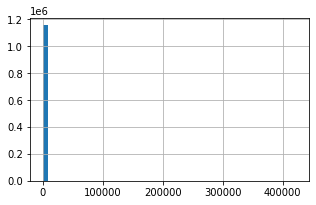

In [5]:
plt.figure(figsize=(5,3))
df.duration.hist(bins=50);

In [6]:
df = df[(df.duration <= 60) & (df.duration >= 1)] 

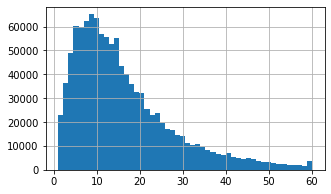

In [7]:
plt.figure(figsize=(5,3))
df.duration.hist(bins=50);

In [8]:
1154112 - df.shape[0]

44286

**4) What's the fractions of missing values for the pickup location ID?**

In [9]:
round(df.PUlocationID.isna().sum()/df.shape[0], 2)

0.84

### Fit LR model

In [5]:
df = read_dataset('data/fhv_tripdata_2021-01.parquet')

In [6]:
train_dicts = df[categorical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

***5)  Dimensionality after OHE***

In [7]:
X_train.shape[1]

525

***6) RMSE on train***

In [8]:
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(f'RMSE on train: {mean_squared_error(y_train, y_pred, squared=False):.4}')
print(f'r^2 on train: {r2_score(y_train, y_pred):.4}')

RMSE on train: 10.53
r^2 on train: 0.1693


**7) RMSE on validation**

In [9]:
df_valid = read_dataset('data/fhv_tripdata_2021-02.parquet')

valid_dicts = df_valid[categorical].to_dict(orient='records')
X_valid = dv.transform(valid_dicts)

y_valid = df_valid[target].values
y_pred = lr.predict(X_valid)

print(f'RMSE on validation: {mean_squared_error(y_valid, y_pred, squared=False):.4}')

RMSE on validation: 11.01


### Add data from  taxi zones

In [10]:
lookup = pd.read_csv('data/taxi+_zone_lookup.csv')
lookup.Borough = lookup.Borough.apply(lambda x: x if x != 'Unknown' else None)
lookup.LocationID = lookup.LocationID.fillna(-1).astype(int).astype(str)

category2 = ['Borough', 'Zone', 'service_zone']
lookup[category2] = lookup[category2].fillna('').astype(str)

In [76]:
lookup[:3]

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone


In [11]:
df_expanded = df.join(lookup.set_index('LocationID'), on='PUlocationID').\
                 join(lookup.set_index('LocationID'), on='DOlocationID', rsuffix='DOI')

In [12]:
meta = [ 'Borough', 'Zone', 'service_zone', 'BoroughDOI', 'ZoneDOI',
       'service_zoneDOI']

In [13]:
df_expanded[meta] = df_expanded[meta].fillna('')
train_dicts = df_expanded[ meta ].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(f'RMSE on train: {mean_squared_error(y_train, y_pred, squared=False):.4}')

RMSE on train: 10.54


### Add daytime info

In [16]:
df['week'] = df.pickup_datetime.dt.weekday
df['hour'] = df.pickup_datetime.dt.hour

In [18]:
train_dicts = df[categorical + ['week', 'hour']].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(f'RMSE on train: {mean_squared_error(y_train, y_pred, squared=False):.4}')
print(f'r^2 on train: {r2_score(y_train, y_pred):.4}')

RMSE on train: 10.51
r^2 on train: 0.1724


In [19]:
df_valid['week'] = df_valid.pickup_datetime.dt.weekday
df_valid['hour'] = df_valid.pickup_datetime.dt.hour

valid_dicts = df_valid[categorical].to_dict(orient='records')
X_valid = dv.transform(valid_dicts)

y_valid = df_valid[target].values
y_pred = lr.predict(X_valid)

print(f'RMSE on train: {mean_squared_error(y_valid, y_pred, squared=False):.4}')

RMSE on train: 11.01
